In [453]:
import pymzml
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.signal import savgol_filter
sns.set(rc={'figure.figsize': (12, 3)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

# Motivation

High-performance liquid chromatography (HPLC) is a technique enabling separation, identification, and quantification of molecules in biological mixtures. HPLC data is typically represented in a form of chromatograms -- signals of detected molecules separated in time. Chromatographic peaks are typically compared against reference standards, which allows for the ellucidation of underlying molecular structures.

<p align = "center">
<img src = "figs/hplc_intro.png" width="500">
</p>
<p align = "center">
Fig.1 - Toy example of a chromatogram showing the signals of two separated molecules.
</p>

However, the key limitation of such approach is a presence of different kinds of noise corrupting the data. This work shows how Savitzky-Golay filtering and ARIMA model can be employed in order to distinguish true signals from noise.

<p align = "center">
<img src = "figs/hplc_noise.png" width="500">
</p>
<p align = "center">
Fig.2 - Example of noise in liquid chromatography.
</p>

Sources of the figures:

https://sielc.com/hplc-method-for-analysis-of-dopamine-and-serotonin

https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=nanomate&logNo=110003143650

In [454]:
# Build extracted ion chromatogram at given m/z
def peak_in_window(spectrum, win_mz, win_r):
    """
    Returns the highest peak of `spectrum` at m/z range (`win_mz` - `win_r`, `win_mz` + `win_r`).
    The peak is represented as a triplet (retention time, m/z, intensity).
    If there is no peak at the given range returns (0, 0, 0).
    """
    peak_idx = np.argwhere((spectrum.mz > win_mz - win_r) & (spectrum.mz < win_mz + win_r))
    if peak_idx.size == 0:
        return np.array([0, 0, 0])
    cand_mzs, cand_int = spectrum.mz[peak_idx], spectrum.i[peak_idx]
    highest_peak = np.argmax(cand_int)
    return np.concatenate([[spectrum.scan_time_in_minutes()], cand_mzs[highest_peak], cand_int[highest_peak]])

def build_xic(msdata, win_mz, win_r=0.5):
    """
    Builds extracted ion chromatogram (XIC) in m/z range (`win_mz` - `win_r`, `win_mz` + `win_r`).
    """
    return np.vstack([peak_in_window(spectrum, win_mz, win_r) for spectrum in msdata if spectrum.ms_level == 1])

def build_xic_ts(msdata, win_mz, win_r=0.5):
    """
    Builds extracted ion chromatogram (XIC) in m/z range (`win_mz` - `win_r`, `win_mz` + `win_r`) as a discrete time series.
    """
    return build_xic(msdata=msdata, win_mz=win_mz, win_r=win_r)[:, 2]

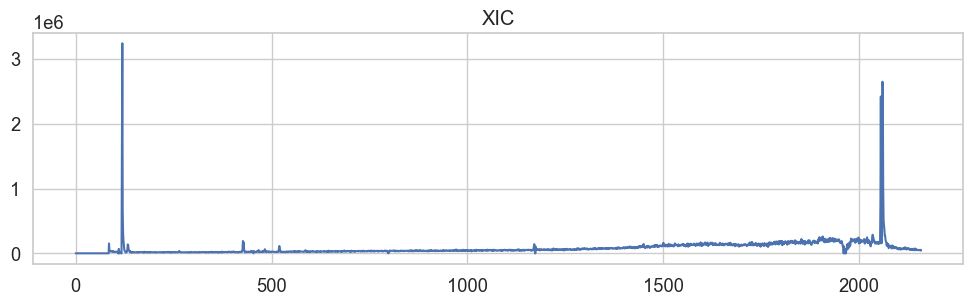

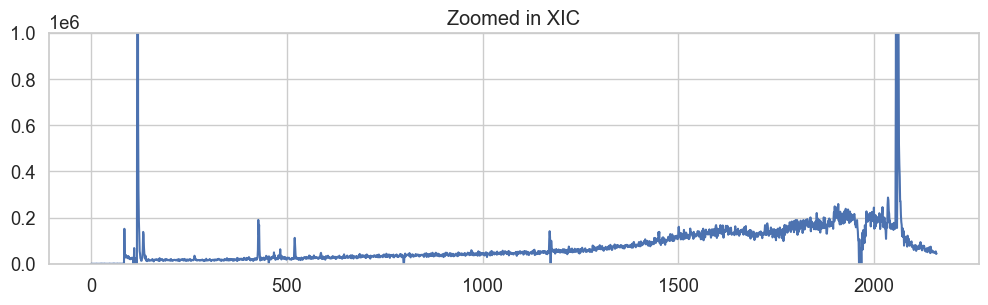

In [455]:
# Build discrete-time XIC at 130 m/z (130 is ~arbitrary).
msdata = pymzml.run.Reader('data/20210701_27_Piper17_1uL.mzML', MS_precisions={1 : 1e-4})
ts = build_xic_ts(msdata, win_mz=134)

# Visualize time series
plt.figure()
sns.lineplot(x=range(ts.shape[0]), y=ts)
plt.title('XIC')
plt.show()
plt.figure()
sns.lineplot(x=range(ts.shape[0]), y=ts)
plt.title('Zoomed in XIC')
plt.ylim(0, 0.1e7)
plt.show()

## ARIMA

Chromatograms are time series which ideally should not contain anything but "sharp Gaussian bumps". Since such "bumps" are by principle independent they cannot be forecasted. The idea of the implemented method is to fit ARIMA model to a chromatogram and treat prediction errors (i.e. residues) as inverse measures of signal noisiness: the lower the error, the more likely the signal is noise.

ARIMA(1, 0, 0), "n" trend | MAE: 25569.35


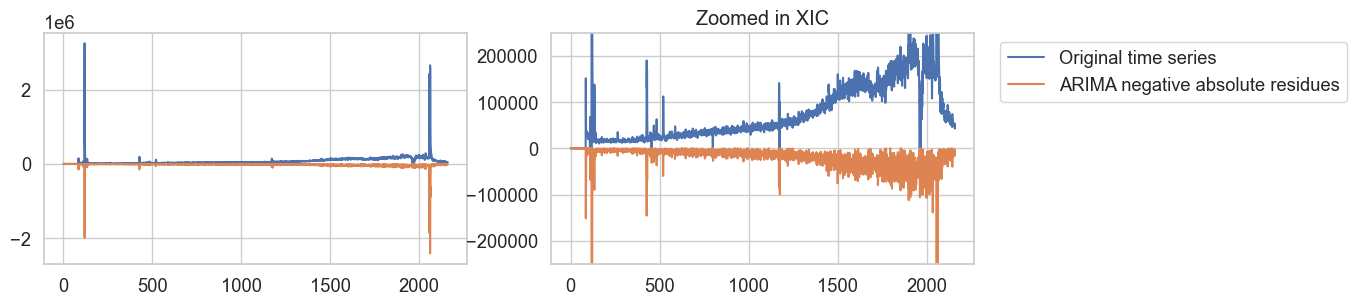

ARIMA(1, 0, 0), "t" trend | MAE: 18858.32


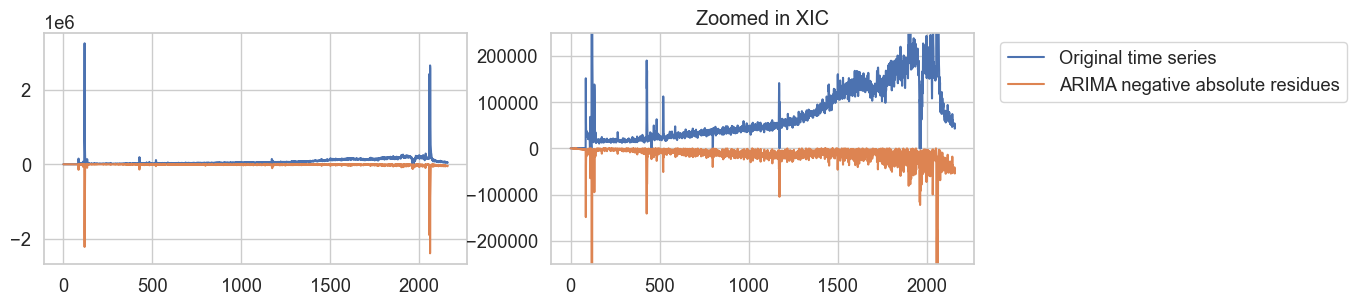

ARIMA(2, 0, 0), "t" trend | MAE: 20692.17


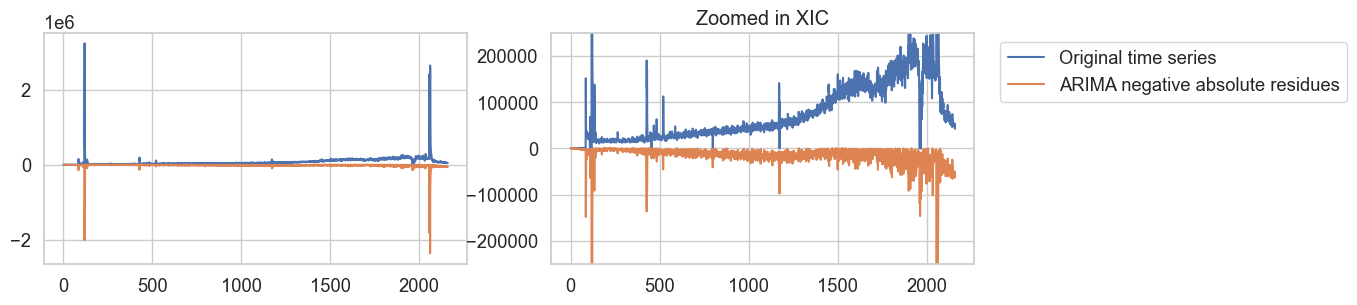

ARIMA(1, 1, 0), "t" trend | MAE: 16916.65


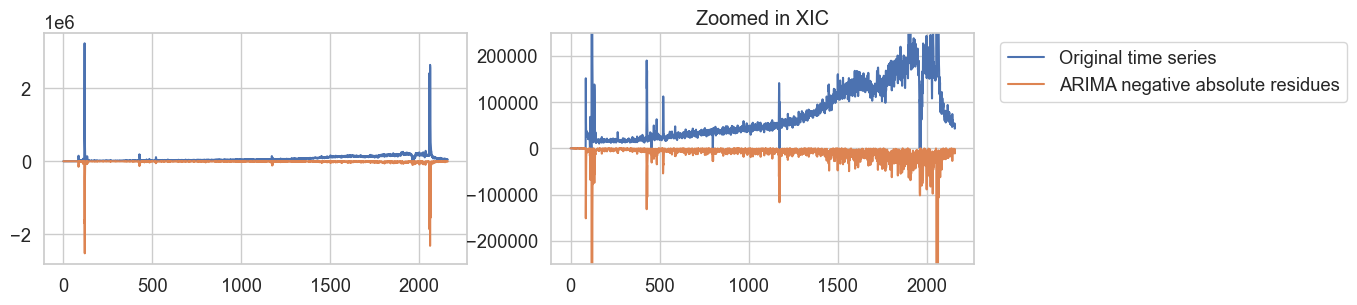

ARIMA(2, 1, 2), "t" trend | MAE: 18096.51


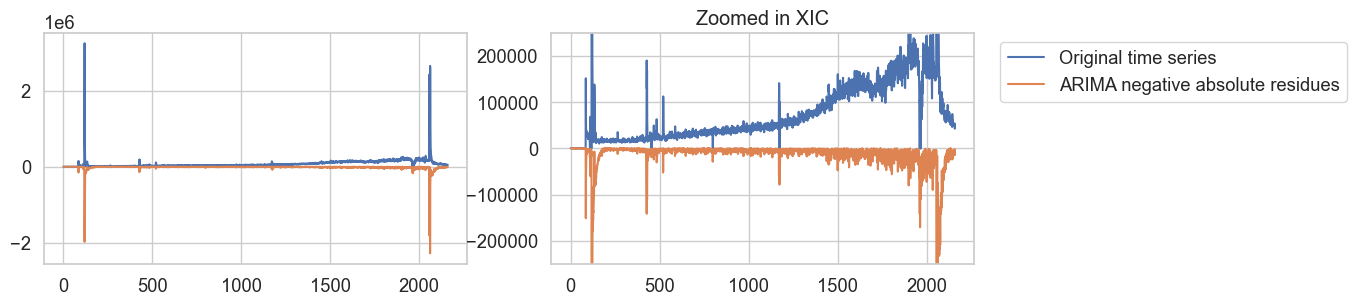

ARIMA(0, 1, 2), "t" trend | MAE: 17682.78


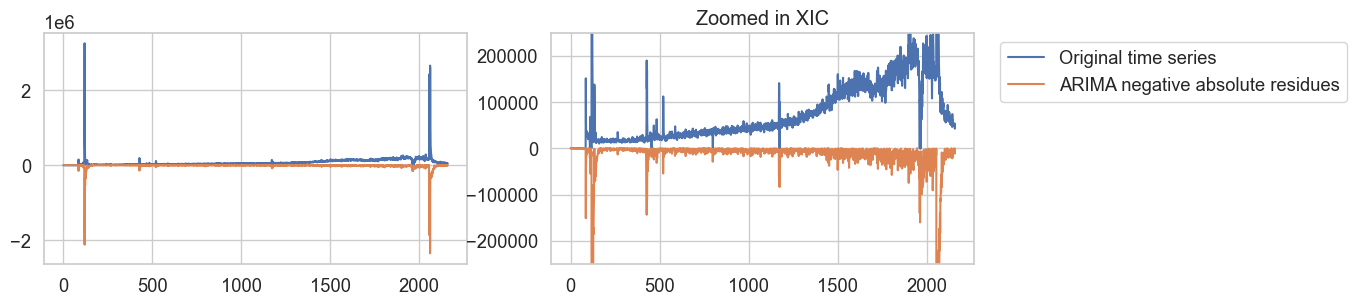

In [456]:
# Investigate different configurations of the ARIMA model
for order, trend in [
    ((1, 0, 0), 'n'), ((1, 0, 0), 't'), ((2, 0, 0), 't'),
    ((1, 1, 0), 't'), ((2, 1, 2), 't'), ((0, 1, 2), 't')
]:

    model = sm.tsa.arima.ARIMA(ts, order=order, trend=trend, concentrate_scale=True).fit()
    print(f'ARIMA{order}, "{trend}" trend | MAE: {model.mae:.2f}')

    fig, axes = plt.subplots(1, 2)
    axes[1].set_title('XIC')
    sns.lineplot(ax=axes[0], x=range(ts.shape[0]), y=ts)
    sns.lineplot(ax=axes[0], x=range(model.resid.shape[0]), y=-np.abs(model.resid))
    axes[1].set_title('Zoomed in XIC')
    axes[1].set_ylim(-0.25e6, 0.25e6)
    sns.lineplot(ax=axes[1], x=range(ts.shape[0]), y=ts, label='Original time series')
    sns.lineplot(ax=axes[1], x=range(model.resid.shape[0]), y=-np.abs(model.resid), label='ARIMA negative absolute residues')
    plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1))
    plt.show()

ARIMA(1, 1, 0) with a linear trend leads to the lowest mean absolute error on the considered chromatogram and is used for the further analysis. Noteworthy, ARIMA without the trend is not capable of modelling drifting noise (~1250 - ~1750 time steps; first plot) as good as ARIMA with a linear trend. Furthermore, the first order of differentiation increases the amplitude of the residues which is a desired effect to distinguish noise from true signals.

In [457]:
best_order = (1, 1, 0)
best_trend = 't'

Having the residues of the fitted model associated with each time step, one can use them to classify the corresponding signals. If a residue lies in a "wide" interquartile range, it is considered to be a noise. Otherwise, the signal is classified as a true signal indicating the detection of a molecule.

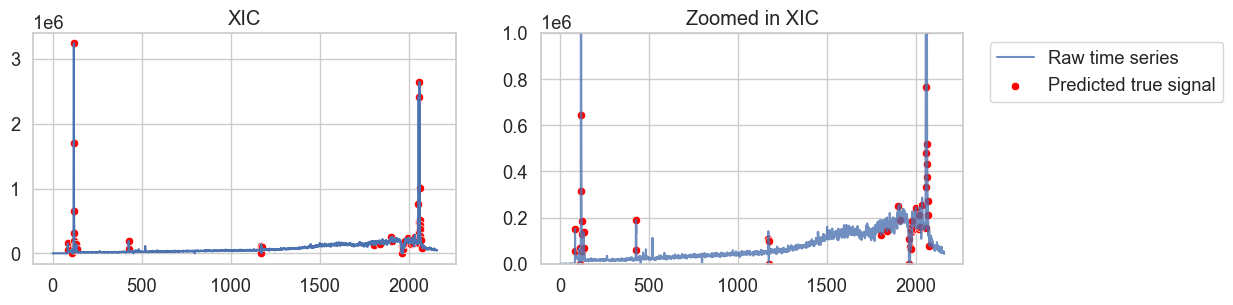

In [458]:
model = sm.tsa.arima.ARIMA(ts, order=best_order, trend=best_trend, concentrate_scale=True).fit()

def out_iqr_mask(x):
    ql = np.quantile(x, 0.1)
    qu = np.quantile(x, 0.9)
    iqr = qu - ql
    return (x < ql - 1.5 * iqr) | (x > qu + 1.5 * iqr)
peaks = out_iqr_mask(model.resid)

fig, axes = plt.subplots(1, 2)
axes[0].set_title('XIC')
sns.lineplot(ax=axes[0], x=range(ts.shape[0]), y=ts)
sns.scatterplot(ax=axes[0], x=np.arange(ts.shape[0])[peaks], y=ts[peaks], color='red')
axes[1].set_ylim(0, 1e6)
axes[1].set_title('Zoomed in XIC')
sns.lineplot(ax=axes[1], x=range(ts.shape[0]), y=ts, alpha=0.8, label='Raw time series')
sns.scatterplot(ax=axes[1], x=np.arange(ts.shape[0])[peaks], y=ts[peaks], color='red', label='Predicted true signal')
plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1))
plt.show()

Overall, ARIMA classifies signals roughly as expected. However, there are two issues that can be improved: the model is not robust enough (signals at time steps ~1750 - ~1900 classified as being true), the model does not have a perfect recall (peak at time step ~505 is classified as noise). The further section shows that preliminary Savitzky-Golay smoothing can adress both of the issues (at least to some extent).

## Savitzky-Golay smoothing

Let us focus on another chromatogram better expressing the issue of robustness. The chromatogram displayed below has a long interval of ascending and descending noise (time steps ~1750 - ~1950).

No filter (114 signals predicted)


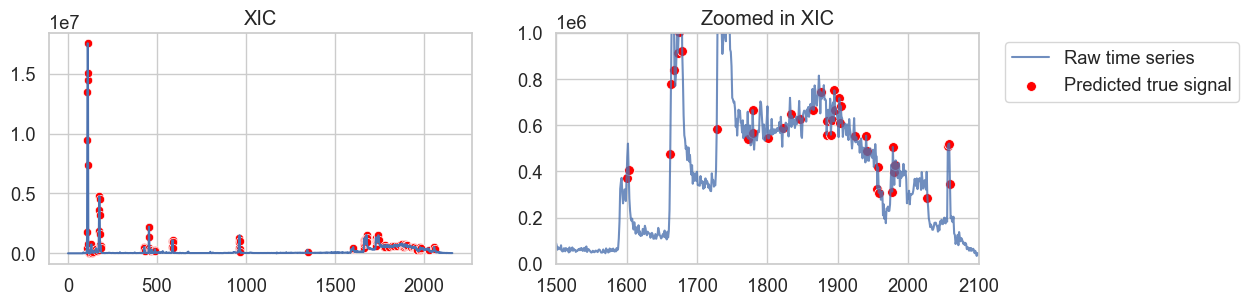

Moving average filter (123 signals predicted)


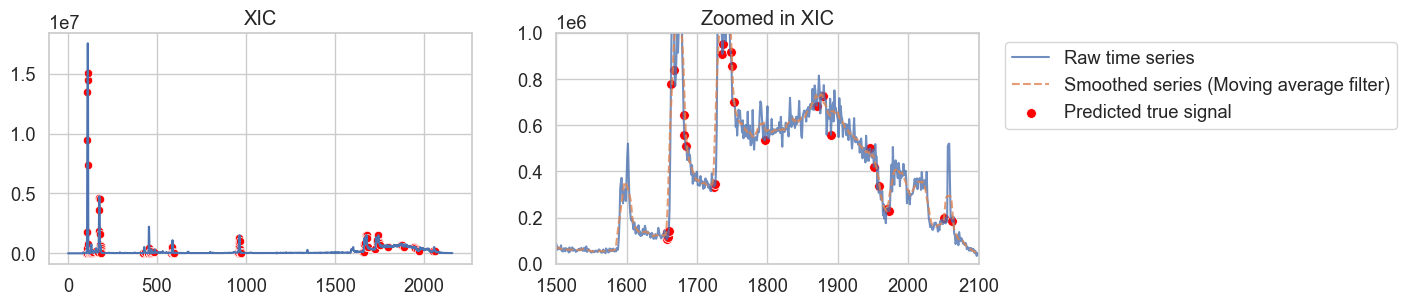

Savitzky-Golay filter (131 signals predicted)


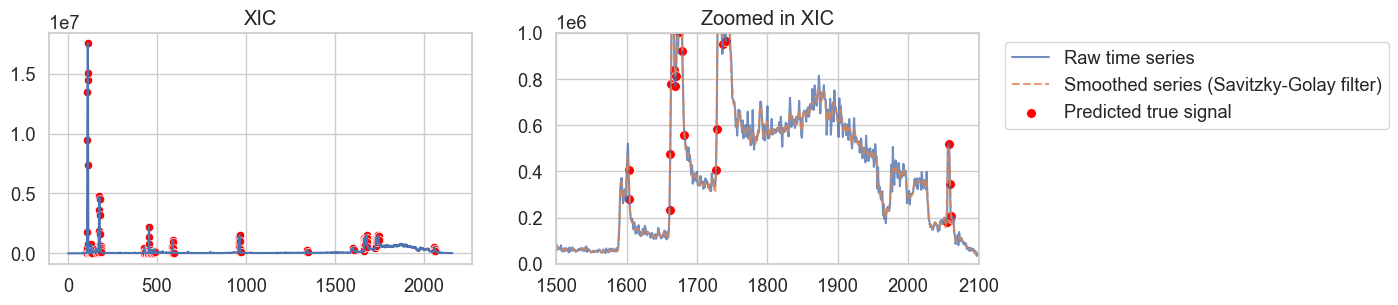

In [459]:
ts_s = build_xic_ts(msdata, 151)

def savgol_tranform(ts):
    return savgol_filter(ts, 11, 4)  # window size 11, polynomial order 4

ts_sav = savgol_tranform(ts_s)
win_size = 11
ts_ma = np.convolve(ts_s, np.ones(win_size), 'same') / win_size

for name, x in [('No filter', ts_s), ('Moving average filter', ts_ma), ('Savitzky-Golay filter', ts_sav)]:

    model = sm.tsa.arima.ARIMA(x, order=best_order, trend=best_trend, concentrate_scale=True).fit()
    peaks = out_iqr_mask(model.resid)
    print(f'{name} ({peaks.sum()} signals predicted)')

    fig, axes = plt.subplots(1, 2)
    axes[0].set_title('XIC')
    sns.lineplot(ax=axes[0], x=range(ts_s.shape[0]), y=ts_s)
    sns.scatterplot(ax=axes[0], x=np.arange(ts_s.shape[0])[peaks], y=ts_s[peaks], color='red')
    axes[1].set_xlim(1500, 2100)
    axes[1].set_ylim(0, 1e6)
    axes[1].set_title('Zoomed in XIC')
    sns.lineplot(ax=axes[1], x=range(ts_s.shape[0]), y=ts_s, alpha=0.8, label='Raw time series')
    if name != 'No filter':
        sns.lineplot(ax=axes[1], x=range(x.shape[0]), y=x, linestyle='--', alpha=0.8, label=f'Smoothed series ({name})')
    sns.scatterplot(ax=axes[1], x=np.arange(ts_s.shape[0])[peaks], y=ts_s[peaks], color='red', s=50, label='Predicted true signal')
    plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1))
    plt.show()

Prior Savitzky-Golay pre-processing allows ARIMA to correctly classify the signals at time steps ~1750 - ~1950 as noise. Overall, it makes the procedure more robust and allows it to better retain the structure of true signals by predicting more true data points of individual peaks.

Let is now look at the result of applying Savitzky-Golay smoothing to the original chromatogram.

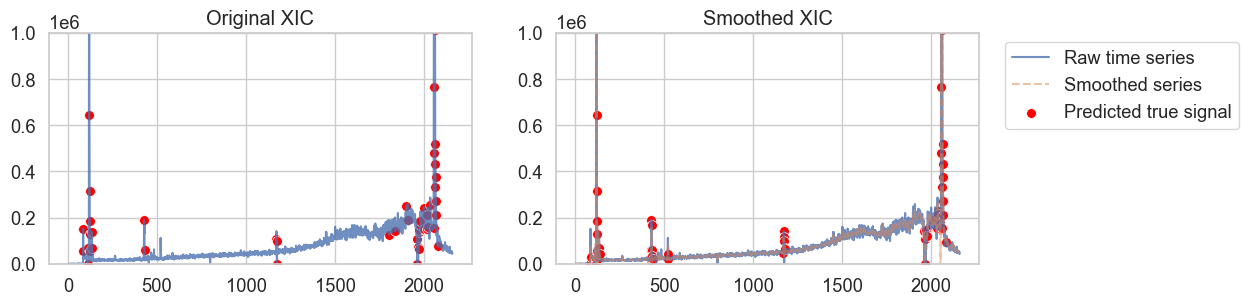

In [460]:
fig, axes = plt.subplots(1, 2)
model = sm.tsa.arima.ARIMA(ts, order=best_order, trend=best_trend, concentrate_scale=True).fit()
peaks = out_iqr_mask(model.resid)
axes[0].set_title('Original XIC')
sns.lineplot(ax=axes[0], x=range(ts.shape[0]), y=ts, alpha=0.8)
sns.scatterplot(ax=axes[0], x=np.arange(ts.shape[0])[peaks], y=ts[peaks], color='red', s=50)

axes[1].set_title('Smoothed XIC')
ts_sav = savgol_tranform(ts)
model = sm.tsa.arima.ARIMA(ts_sav, order=best_order, trend=best_trend, concentrate_scale=True).fit()
peaks = out_iqr_mask(model.resid)
sns.lineplot(ax=axes[1], x=range(ts.shape[0]), y=ts, alpha=0.8, label='Raw time series')
sns.lineplot(ax=axes[1], x=range(ts_sav.shape[0]), y=ts_sav, linestyle='--', alpha=0.5, label=f'Smoothed series')
sns.scatterplot(ax=axes[1], x=np.arange(ts.shape[0])[peaks], y=ts[peaks], color='red', s=50, label='Predicted true signal')
for i in range(2): axes[i].set_ylim(0, 1e6)
plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1))
plt.show()

Noise at the time steps ~1750 - ~1950 is classified as noise and the relatively high signal at the time step of ~505 is now predicted as being true.

# Validation examples

Results of the method of other chromatograms.

XIC @ 115±0.5 m/z


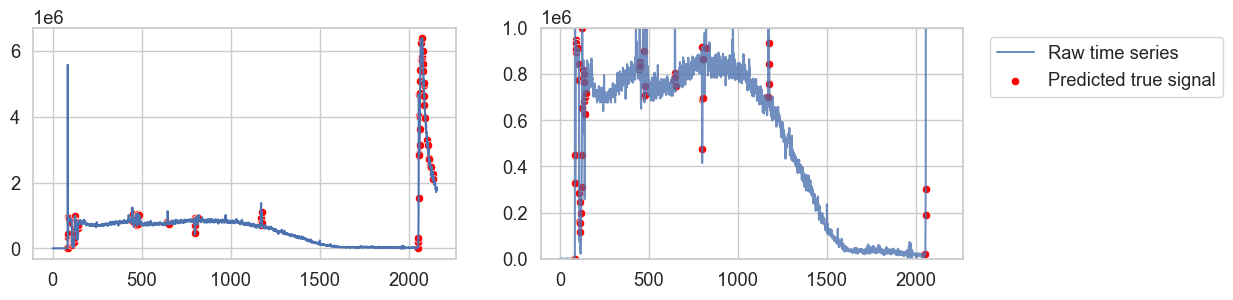

XIC @ 148±0.5 m/z


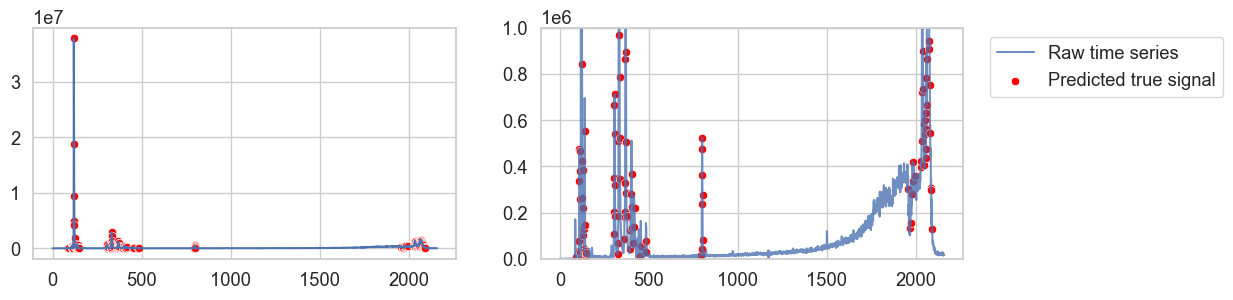

XIC @ 155±0.5 m/z


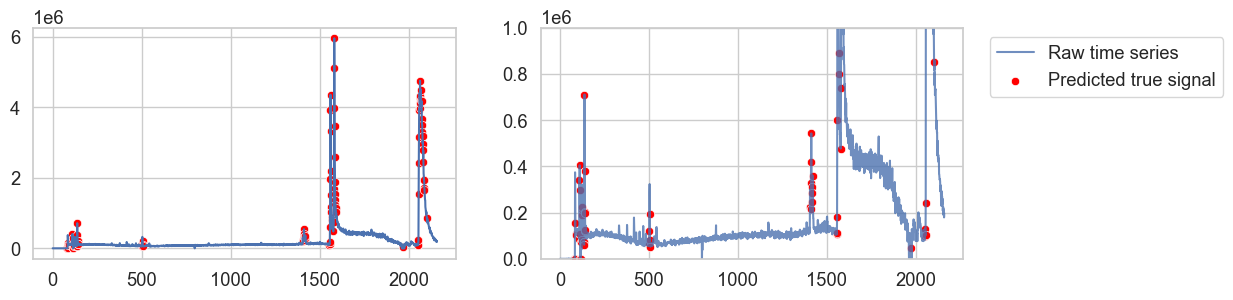

XIC @ 199±0.5 m/z


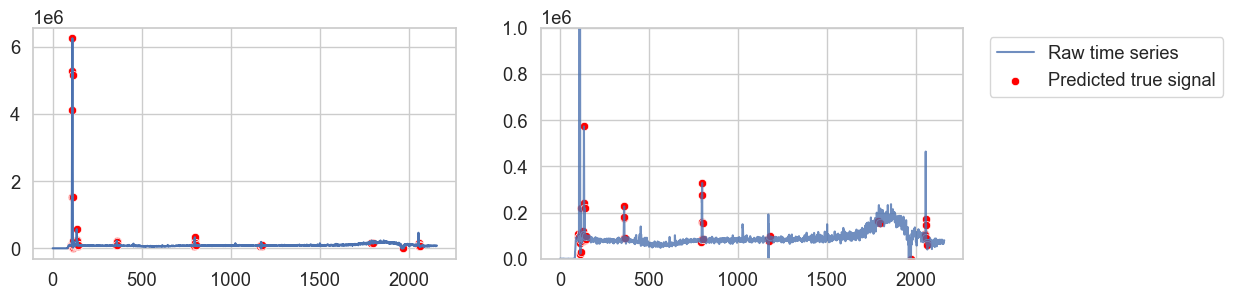

XIC @ 227±0.5 m/z


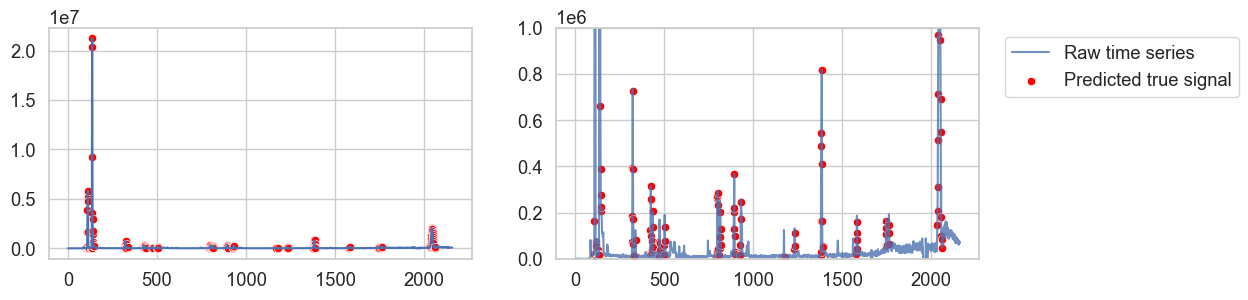

In [461]:
win_mz = 0.5
for mz in [115, 148, 155, 199, 227]:  # Some m/z values associated with dense XICs
    print(f'XIC @ {mz}±{win_mz} m/z')

    ts = build_xic_ts(msdata, mz, win_r=0.5)
    ts_sav = savgol_tranform(ts)
    model = sm.tsa.arima.ARIMA(ts_sav, order=best_order, trend=best_trend, concentrate_scale=True).fit()
    peaks = out_iqr_mask(model.resid)

    fig, axes = plt.subplots(1, 2)
    sns.lineplot(ax=axes[0], x=range(ts.shape[0]), y=ts)
    sns.scatterplot(ax=axes[0], x=np.arange(ts.shape[0])[peaks], y=ts[peaks], color='red')
    axes[1].set_ylim(0, 1e6)
    sns.lineplot(ax=axes[1], x=range(ts.shape[0]), y=ts, alpha=0.8, label='Raw time series')
    sns.scatterplot(ax=axes[1], x=np.arange(ts.shape[0])[peaks], y=ts[peaks], color='red', label='Predicted true signal')
    plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1))
    plt.show()